# Gather protein structures and amino acid features
* This notebook generates a dict with diverse protein features for each protein
* Requires data from notebook #1

 **Include sequence alignments to the analysis**
* MSAs were generated using PSI-BLAST using the non-redudant protein sequences and limit the msas to 5000 sequences
* Aim: Test whether sequence conservation correlates with insertion tolerance
* The sequences were fetched via psi-blast with a limit of 5000 sequence (insert other params here)
* MSAs were generated using MUSCLE with standard params
    * for large alignments the Super5 algorithm was used instead of PPP
* Kullback-Leibler-Divergence is taken as a measure for conservation

TODO: remove context radius for simplicity

In [1]:
import pickle
import pandas as pd
from Bio import SeqIO
from Bio.PDB import *
import matplotlib.pyplot as plt
import matplotlib as matplotlib

from utils.plotting import *
from utils.processing import *

# set styles
plt.style.use('./utils/domain_ins.mplstyle')
plt.rcParams['svg.fonttype'] = 'none'

/home/jm38sywy/miniconda3/envs/transformer/lib/python3.8/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


### Define parameters

In [2]:
base = '/work/projects/project01640/jm/domain_insertion/DI_screen'
in_folder = f'{base}/analysis/input_data'
data_folder = f'{base}/analysis/output_datasets'
fig_folder = f'{base}/analysis/figures'
primary_proteins = {rec.id : rec.seq for rec in SeqIO.parse(f'{in_folder}/proteins.fasta', 'fasta')}

#sequencing data:
# import analysis dict
with open(f'{data_folder}/analysis_dict.pickle', 'rb') as input:
    analysis_dict = pickle.load(input)
input.close()

# background AA frequences Swissprot release 2022_04
background_AA ={'A':0.0825, 'Q':0.0393, 'L':0.0965, 'S':0.0664, 'R':0.0553, 'E':0.0672, 'K':0.0580, 'T':0.0535, 'N':0.0406, 'G':0.0707,
                'M':0.0241, 'W':0.0110, 'D':0.0546, 'H':0.0227, 'F':0.0386, 'Y':0.0292, 'C':0.0138, 'I':0.0591, 'P':0.0474, 'V':0.0686}

#define features that should be taken into account 
feature_dict_radius = {'Hydrophobicity':'PRAM900101', 'Flexibility_idx':'BHAR880101', 'Molecular_weight':'FASG760101', 'Average_volume':'PONJ960101', 
'Positive_charge':'FAUJ880111', 'Negative_charge':'FAUJ880112', 'Net_charge':'KLEP840101', 'Radius_of_gyration':'LEVM760105',
 'Side-chain_stab_idx':'TAKK010101', 'Stability_scale_atom':'ZHOH040101', 'Stability_scale_experiment':'ZHOH040102', 'Buriability':'ZHOH040103'}
feature_dict_sequential = {'Linker_idx_Suyama':'SUYM030101', 'Linker_idx_George':'GEOR030101', 'Linker_idx_Bae':'BAEK050101'}

### Fetch features from AAindex DB, MSAs adn PDB files

In [3]:
feat_dict_radius = import_features(feature_dict_radius)
feat_dict_sequential = import_features(feature_dict_sequential)

In [4]:
#process alignments and store data in dict
data_dict = {}
uniprot = {'AraC', 'TVMV', 'Flp', 'SigF'}
for protein in uniprot:
        data_dict[f'{protein}_data']={}
        data_dict[f'{protein}_data']['alignment_df'], data_dict[f'{protein}_data'][f'{protein}_positions'],  data_dict[f'{protein}_data']['alignment_counts'] = process_alignment(f'{protein}_ref_aln.afa', protein)
        data_dict[f'{protein}_data']['KLD'], data_dict[f'{protein}_data']['query_idx'] = KLD(data_dict[f'{protein}_data']['alignment_counts'], background_AA, data_dict[f'{protein}_data'][f'{protein}_positions'])
        data_dict[f'{protein}_data'] = insertion_stats(data_dict[f'{protein}_data']['query_idx'], primary_proteins[protein], data_dict[f'{protein}_data'])
        del data_dict[f'{protein}_data']['alignment_df'], data_dict[f'{protein}_data'][f'{protein}_positions'], data_dict[f'{protein}_data']['alignment_counts'], data_dict[f'{protein}_data']['query_idx']
        data_dict[f'{protein}_data'] = pd.DataFrame.from_dict(data_dict[f'{protein}_data'])


In [5]:
#construct dataset
full_dataset = {}
input_pdbs = ['AraC', 'Flp', 'SigF','TVMV']

for protein in input_pdbs:  
    full_dataset[f'{protein}'] = {}
    full_dataset[f'{protein}']['2'] = collect_training_data(2, data_dict[f'{protein}_data'], protein, feat_dict_radius, feat_dict_sequential, primary_proteins, analysis_dict, in_folder)

#dump the current dataset to pickle
with open(f'{data_folder}/proteins_training.pickle', 'wb') as f:
    pickle.dump(full_dataset, f) 
f.close() 

/home/jm38sywy/miniconda3/envs/transformer/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2363
  warnings.warn(


/work/projects/project01640/jm/domain_insertion/DI_screen/analysis/utils/plotting.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,5))


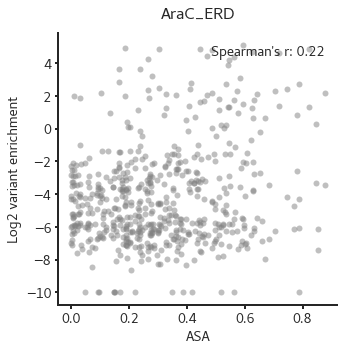

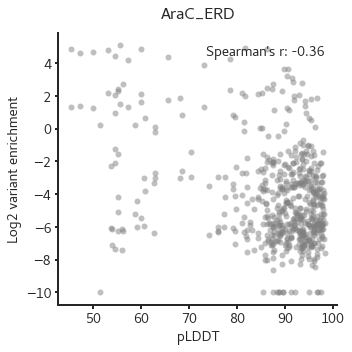

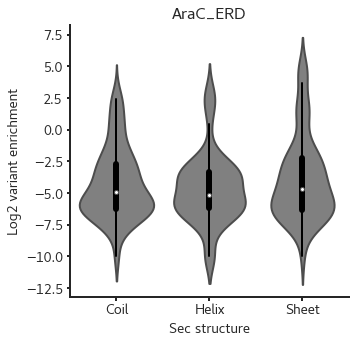

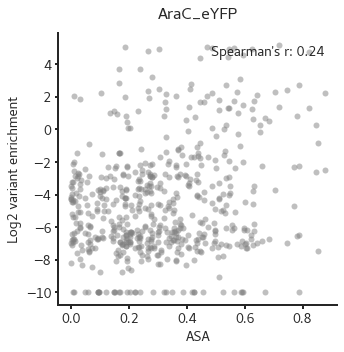

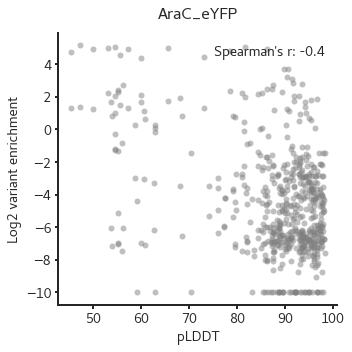

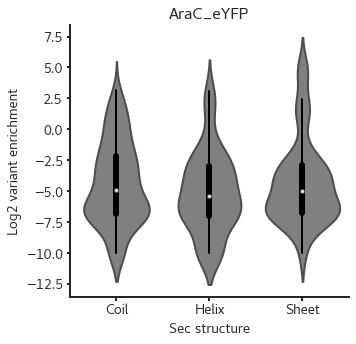

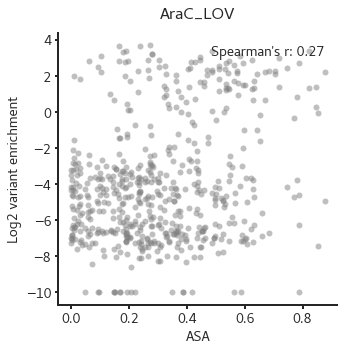

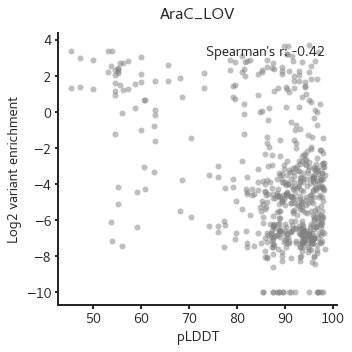

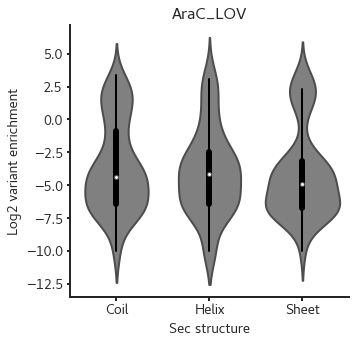

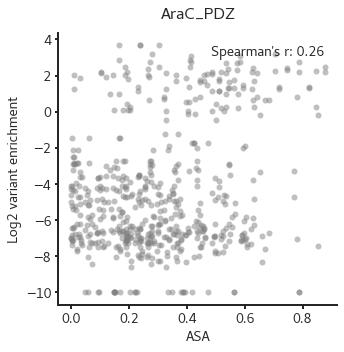

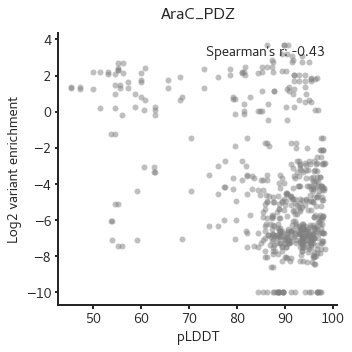

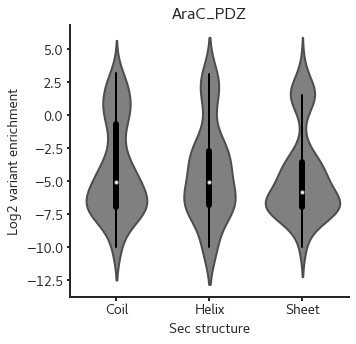

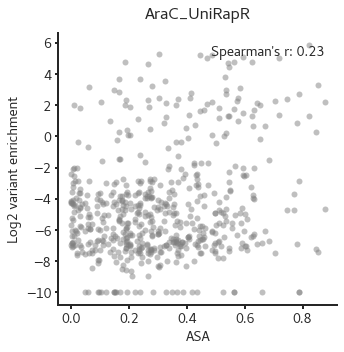

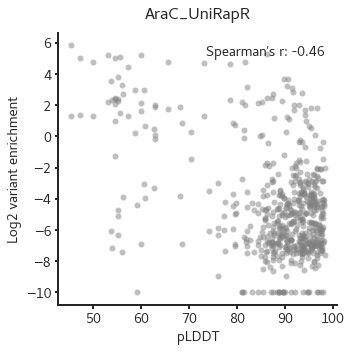

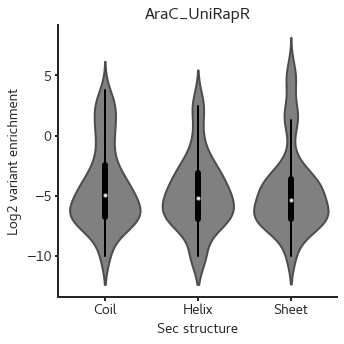

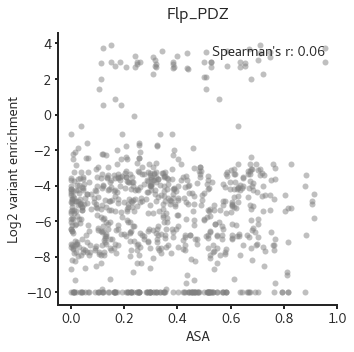

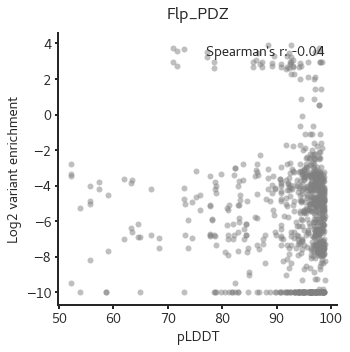

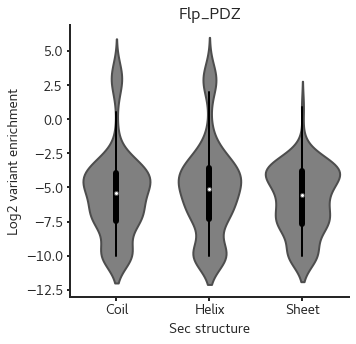

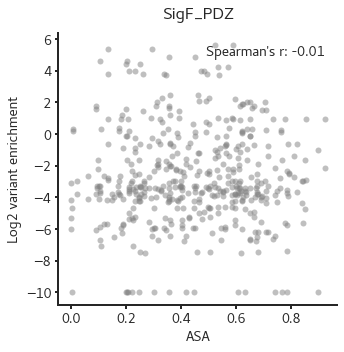

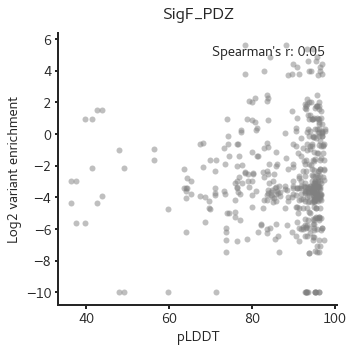

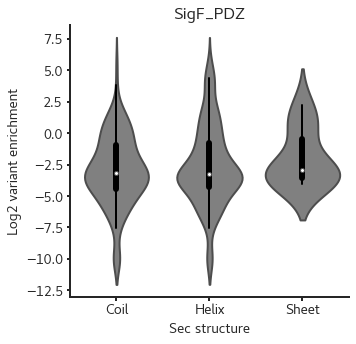

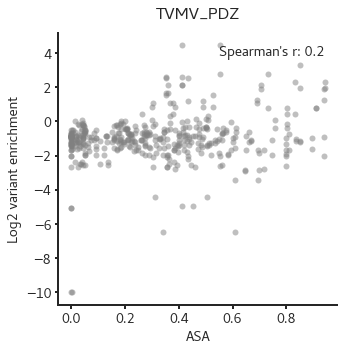

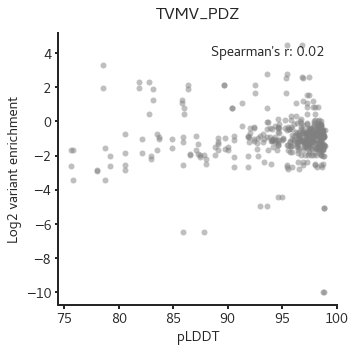

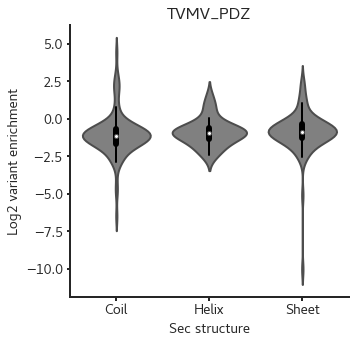

In [6]:
for name, radius_dict in full_dataset.items():
    for name, df in radius_dict.items():
        df.dropna(inplace=True)

property_dict = {}
for i in analysis_dict.items():
        #select samples from second enrichment and average them, if 2 replicates are available
        temp_dict = {}
        for idx, frame in i[1].items():
            if len(idx) == 2 and idx[1] == '2':
                temp_dict[idx] = frame
        if len(temp_dict) == 1: 
            out_df = list(temp_dict.values())[0]['log']
        elif len(temp_dict) == 2:
            out_df = (temp_dict['12']['log'] + temp_dict['22']['log'])/2
        else:
            continue
        out_df = out_df.to_frame()
        complete_df = pd.concat([out_df.reset_index(), full_dataset[f'{i[0].split("_")[0]}']['2'].reset_index()], axis=1)
        complete_df.dropna(inplace=True)
        plot_df = complete_df[['log', 'Sec_structure', 'ASA', 'pLDDT']]   
        plot_df = plot_df.iloc[1:-1,:]
        plot_df = pd.melt(plot_df, id_vars=['Sec_structure', 'ASA', 'pLDDT'], value_vars=out_df.columns, value_name='enrichment')
        plot_df['ASA'] =plot_df['ASA'].astype('float')
        plot_df['pLDDT'] =plot_df['pLDDT'].astype('float')
        property_dict[i[0]] = complete_df
        feature_correlation_plot(plot_df, i[0], 'ASA', fig_folder)
        feature_correlation_plot(plot_df, i[0], 'pLDDT', fig_folder)
        violin_plot(plot_df, i[0], 'Sec_structure', fig_folder)
